<a href="https://colab.research.google.com/github/juniperlovato/DiverseMisinformationPaper/blob/main/Final_Visualizations_of_Bootstrapping_confusion_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook generates bootstrap samples from two confusions matrices and compares their MCC scores. We use it to test the significance of biases in results of Lovato et al. (2022).

##Imports and installs

In [1]:
import numpy as np
import scipy
from scipy.stats import spearmanr
from scipy.stats import ttest_ind

In [2]:
#for latex in matpliotlib
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

##Functions for bootstraping and difference of mean test

In [3]:
#function that generates a bootstraped sampled of correlation coefficients
#input: confusion matrix as 4 parameters
#output an array of 10,000 correlation coefficient
def generate_corrcoeff(TP,FN,FP,TN):
  norm = TP+FN+FP+TN
  corrcoeff = []
  for repetition in range(10000):
    a = []
    b = []
    for data in range(norm):
      rn = np.random.randint(norm)
      if rn<TP:
        a.append(1)
        b.append(1)
      elif rn<TP+FN:
        a.append(0)
        b.append(1)
      elif rn<TP+FN+FP:
        a.append(1)
        b.append(0)
      else:
        a.append(0)
        b.append(0)
    corrcoeff.append(scipy.stats.spearmanr(a,b)[0])
  return corrcoeff

In [78]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def find_confidence(array):
  array_has_nan = np.isnan(np.sum(array))
  if array_has_nan:
    return(np.sum(array))
  for quant in np.arange(0.000,1.0,0.001):
    res = np.quantile(array, quant)
    if res>0:
      return(quant - 0.001)
      break
  return(quant)


def complete_visualization(array1,label1,array2,label2,label3,label,ymax,deltax):

  xmin = -deltax
  xmax = deltax
  
  #subtract correlation coefficients from one another
  array = np.subtract(array1,array2)

  #calculate where 0 falls in the resulting quantiles
  confidence = find_confidence(array)
  #express confidence as a "probability" that the null can be rejected
  if confidence<0.5:
    confidence = 1-confidence

  #fix confidence format
  conf_str = f'{confidence:.2f}'
  if conf_str == '1.00':
    conf_str = '0.99'

  plt.rcParams['text.usetex']       = True
  plt.rcParams['font.size']         = 14
  plt.rcParams['font.family']       = 'serif'
  plt.rcParams['font.serif']        = 'Computer Modern Roman'
  plt.rcParams['xtick.major.width'] = 2
  plt.rcParams['xtick.major.size']  = 8
  plt.rcParams['ytick.major.width'] = 2
  plt.rcParams['ytick.major.size']  = 8

  #fit distributions
  (mean1, sigma1) = (np.mean(array1), np.std(array1))
  (mean2, sigma2) = (np.mean(array2), np.std(array2))
  (mean, sigma) = (np.mean(array), np.std(array))
  x = np.linspace(-1, 1, 1000)
  y1 = len(array1) * 0.02 * (1/np.sqrt(2*3.1416*sigma1**2))*np.exp(-0.5*(x-mean1)**2/sigma1**2)
  y2 = len(array2) * 0.02 *(1/np.sqrt(2*3.1416*sigma2**2))*np.exp(-0.5*(x-mean2)**2/sigma2**2)
  y = len(array) * 0.02 *(1/np.sqrt(2*3.1416*sigma**2))*np.exp(-0.5*(x-mean)**2/sigma**2)

  plt.plot(x,y1,c='blue', label=label1, linestyle='dotted')
  plt.plot(x,y2,c='orange', label=label2, linestyle='dashed')
  plt.plot(x,y,c='black', label=label3, linewidth=3)
  plt.legend(loc='upper left', frameon=False)
  plt.xlabel(r'MCC Scores')
  plt.ylabel(r'Bootstrap counts')

  plt.text(xmin+0.03,0.6*ymax,'credibility = %s'%(conf_str))
  plt.text(0.3*xmax,0.8*ymax,label)
  plt.ylim(0,ymax)
  plt.xlim(xmin,xmax)
  plt.savefig('fig.pdf')
  plt.show()

Generate and compare bootstrap samples for two *independent* categories to be compared

In [29]:
# White_Heterophily	"[[495 184]
#   [421 124]]"
# White_Homophily	"[[489 159]
#   [513 211]]"

#Argument key: TP,FN,FP,TN
bootstrap_homoW = generate_corrcoeff(489,159,513,211)
bootstrap_heteroW = generate_corrcoeff(495,184,421,124)

result_bias_W = ttest_ind(bootstrap_homoW,bootstrap_heteroW,equal_var=False)
print(result_bias_W)

Ttest_indResult(statistic=259.67840505922044, pvalue=0.0)


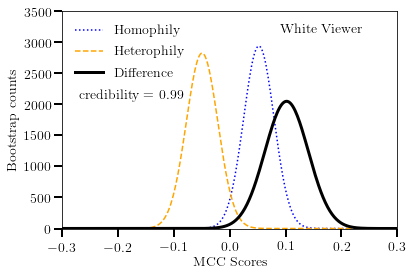

In [30]:
complete_visualization(bootstrap_homoW,'Homophily',bootstrap_heteroW,'Heterophily','Difference','White Viewer',3500,0.3)

In [31]:
#Argument key: TP,FN,FP,TN
#Male and female participants watching male videos

bootstrap_Male_Male = generate_corrcoeff(355,320,105,138)
bootstrap_Female_Male = generate_corrcoeff(243,246,99,96)

result_bias_Gender = ttest_ind(bootstrap_Male_Male,bootstrap_Female_Male,equal_var=False)
print(result_bias_Gender)

Ttest_indResult(statistic=187.67348857504035, pvalue=0.0)


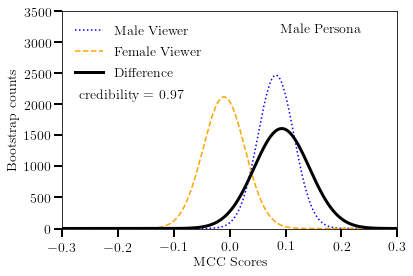

In [32]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Male_Male,'Male Viewer',bootstrap_Female_Male,'Female Viewer', 'Difference', 'Male Persona', 3500,0.3)

In [33]:
#Male and female viewers of POC videos

bootstrap_Male_POC = generate_corrcoeff(427,334,127,118)
bootstrap_Female_POC = generate_corrcoeff(341,298,121,85)

result_bias_Gender = ttest_ind(bootstrap_Male_POC,bootstrap_Female_POC,equal_var=False)
print(result_bias_Gender)


Ttest_indResult(statistic=179.5145480634565, pvalue=0.0)


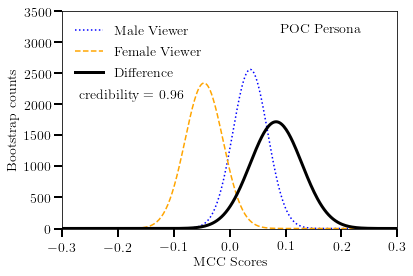

In [34]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Male_POC,'Male Viewer',bootstrap_Female_POC,'Female Viewer', 'Difference', 'POC Persona', 3500,0.3)


In [35]:
#Male and female viewers of white videos

bootstrap_Male_White = generate_corrcoeff(409,415,115,179)
bootstrap_Female_White = generate_corrcoeff(304,344,127,155)

result_bias_Gender = ttest_ind(bootstrap_Male_White,bootstrap_Female_White,equal_var=False)
print(result_bias_Gender)


Ttest_indResult(statistic=168.38650283231436, pvalue=0.0)


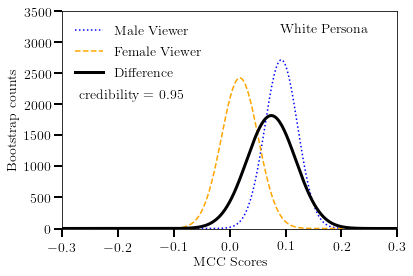

In [36]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Male_White,'Male Viewer',bootstrap_Female_White,'Female Viewer', 'Difference', 'White Persona', 3500,0.3)

In [37]:
#White and POC viewers of female videos

bootstrap_POC_Female = generate_corrcoeff(330,289,92,127)
bootstrap_White_Female = generate_corrcoeff(562,540,174,167)

result_bias_Gender = ttest_ind(bootstrap_POC_Female,bootstrap_White_Female,equal_var=False)
print(result_bias_Gender)

Ttest_indResult(statistic=231.33344083950982, pvalue=0.0)


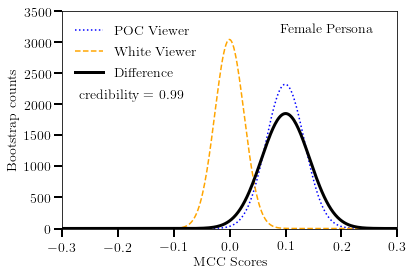

In [38]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_POC_Female,'POC Viewer',bootstrap_White_Female,'White Viewer', 'Difference','Female Persona', 3500,0.3)


In [5]:
#Argument key: TP,FN,FP,TN
# # PersonofColor_with_POC_video "[[306 233]
#  [ 79  90]]"
# # White_with_POC_video "[[462 399]
#  [169 113]]"


bootstrap_White_POC = generate_corrcoeff(462,399,169,113)
bootstrap_POC_POC = generate_corrcoeff(306,233,79,90)

result_bias_race = ttest_ind(bootstrap_White_POC,bootstrap_POC_POC,equal_var=False)
print(result_bias_race)

Ttest_indResult(statistic=-295.6557020951146, pvalue=0.0)


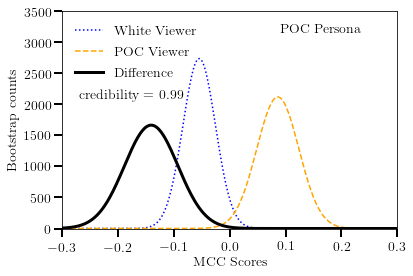

In [6]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_White_POC,'White Viewer',bootstrap_POC_POC,'POC Viewer', 'Difference', 'POC Persona',3500,0.3)

In [7]:
#White and POC viewers of Old videos

bootstrap_POC_Old = generate_corrcoeff(99,90,31,51)
bootstrap_White_Old = generate_corrcoeff(187,160,68,59)

result_bias_Gender = ttest_ind(bootstrap_POC_Old,bootstrap_White_Old,equal_var=False)
print(result_bias_Gender)


Ttest_indResult(statistic=175.97008235236666, pvalue=0.0)


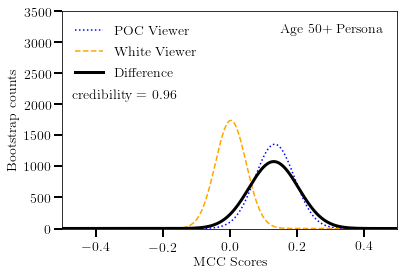

In [8]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_POC_Old,'POC Viewer',bootstrap_White_Old,'White Viewer',  'Difference', 'Age 50+ Persona',3500,0.5)


In [9]:
#different age viewers of Female videos

bootstrap_Young_Female = generate_corrcoeff(150,121,31,67)
bootstrap_Middle_Female = generate_corrcoeff(239,244,63,62)
bootstrap_Old_Female = generate_corrcoeff(503,464,172,165)


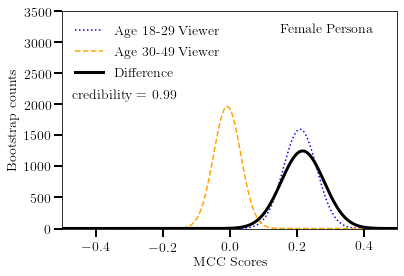

In [10]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Young_Female,'Age 18-29 Viewer', bootstrap_Middle_Female, 'Age 30-49 Viewer', 'Difference', 'Female Persona',3500,0.5)


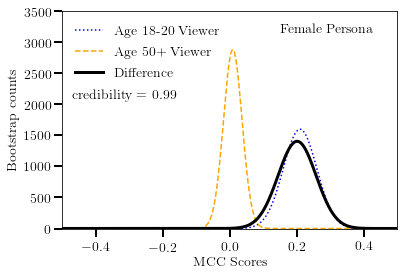

In [11]:
complete_visualization(bootstrap_Young_Female, 'Age 18-20 Viewer', bootstrap_Old_Female, 'Age 50+ Viewer',  'Difference', 'Female Persona',3500,0.5)


In [12]:
#different age viewers of young videos

bootstrap_Young_Young = generate_corrcoeff(117,107,28,51)
bootstrap_Middle_Young = generate_corrcoeff(106,99,28,31)
bootstrap_Old_Young = generate_corrcoeff(239,270,91,94)


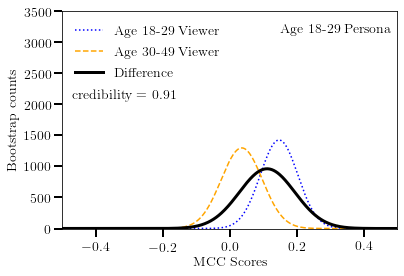

In [38]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Young_Young, 'Age 18-29 Viewer', bootstrap_Middle_Young, 'Age 30-49 Viewer',  'Difference', 'Age 18-29 Persona',3500,0.5)

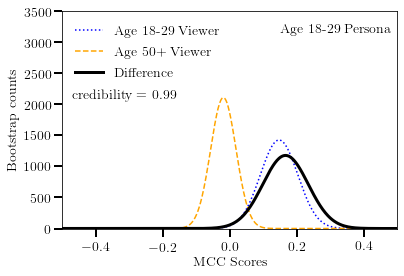

In [39]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Young_Young, 'Age 18-29 Viewer', bootstrap_Old_Young, 'Age 50+ Viewer',  'Difference', 'Age 18-29 Persona',3500,0.5)

In [24]:
#different age viewers of middle-aged videos

bootstrap_Young_Middle = generate_corrcoeff(112,90,34,46)
bootstrap_Middle_Middle = generate_corrcoeff(235,243,64,65)
bootstrap_Old_Middle = generate_corrcoeff(435,363,161,155)


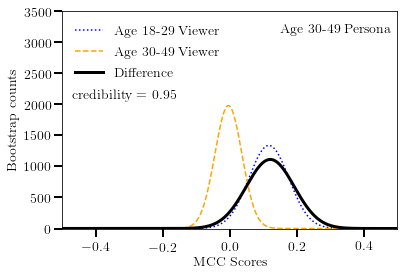

In [16]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Young_Middle, 'Age 18-29 Viewer', bootstrap_Middle_Middle, 'Age 30-49 Viewer', 'Difference', 'Age 30-49 Persona',3500,0.5)


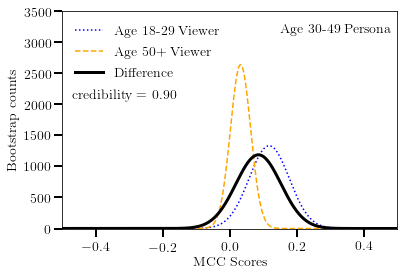

In [26]:
complete_visualization(bootstrap_Young_Middle, 'Age 18-29 Viewer', bootstrap_Old_Middle, 'Age 50+ Viewer', 'Difference', 'Age 30-49 Persona',3500,0.5)


In [27]:
#different age viewers of Male videos

bootstrap_Young_Male = generate_corrcoeff(104,89,33,43)
bootstrap_Middle_Male = generate_corrcoeff(161,166,48,59)
bootstrap_Old_Male = generate_corrcoeff(333,311,123,132)


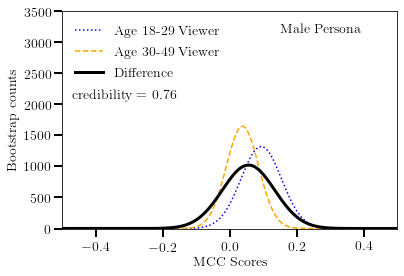

In [19]:
#argument key:  array and label, demographic array
complete_visualization(bootstrap_Young_Male,'Age 18-29 Viewer', bootstrap_Middle_Male, 'Age 30-49 Viewer', 'Difference', 'Male Persona',3500,0.5)


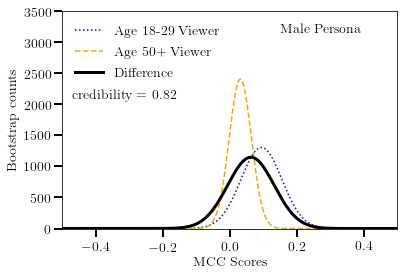

In [29]:
complete_visualization(bootstrap_Young_Male,'Age 18-29 Viewer', bootstrap_Old_Male, 'Age 50+ Viewer', 'Difference', 'Male Persona',3500,0.5)


In [30]:
#different age viewers of POC videos

bootstrap_Young_POC = generate_corrcoeff(148,113,32,41)
bootstrap_Middle_POC = generate_corrcoeff(227,203,63,52)
bootstrap_Old_POC = generate_corrcoeff(393,316,153,110)


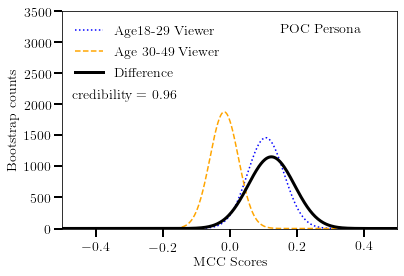

In [31]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Young_POC, 'Age18-29 Viewer', bootstrap_Middle_POC,'Age 30-49 Viewer', 'Difference','POC Persona',3500,0.5)


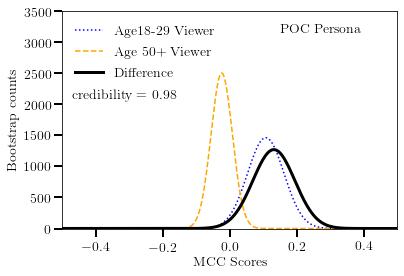

In [32]:
complete_visualization(bootstrap_Young_POC, 'Age18-29 Viewer', bootstrap_Old_POC,'Age 50+ Viewer', 'Difference','POC Persona',3500,0.5)


In [33]:
#different age viewers of White videos

bootstrap_Young_White = generate_corrcoeff(106,102,36,68)
bootstrap_Middle_White  = generate_corrcoeff(174,199,50,71)
bootstrap_Old_White  = generate_corrcoeff(433,458,156,195)

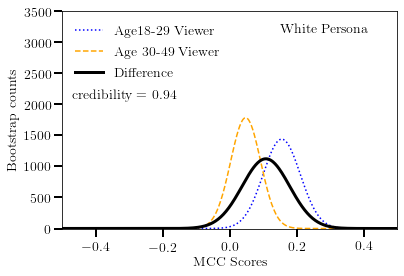

In [34]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Young_White , 'Age18-29 Viewer', bootstrap_Middle_White ,'Age 30-49 Viewer', 'Difference','White Persona',3500,0.5)


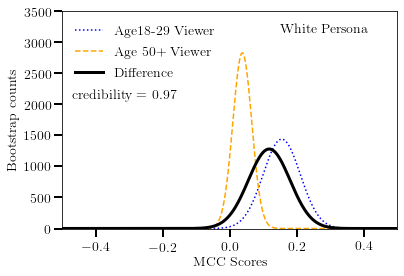

In [35]:
complete_visualization(bootstrap_Young_White, 'Age18-29 Viewer', bootstrap_Old_White,'Age 50+ Viewer', 'Difference','White Persona',3500,0.5)


In [40]:
#different age viewers of middle-aged videos

bootstrap_Young_Middle = generate_corrcoeff(112,90,34,46)
bootstrap_Middle_Middle = generate_corrcoeff(235,243,64,65)
bootstrap_Old_Middle = generate_corrcoeff(435,363,161,155)



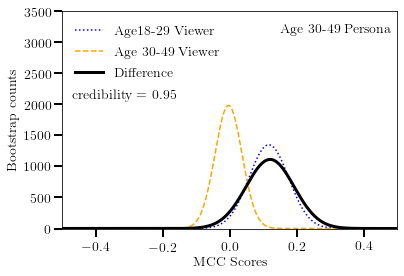

In [41]:
complete_visualization(bootstrap_Young_Middle, 'Age18-29 Viewer', bootstrap_Middle_Middle,'Age 30-49 Viewer', 'Difference','Age 30-49 Persona',3500,0.5)

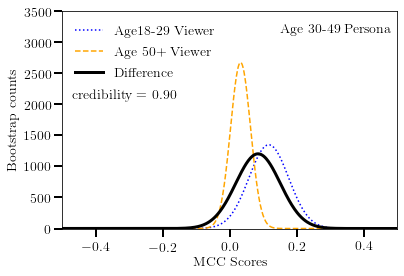

In [42]:
complete_visualization(bootstrap_Young_Middle, 'Age18-29 Viewer', bootstrap_Old_Middle,'Age 50+ Viewer', 'Difference','Age 30-49 Persona',3500,0.5)


In [43]:
#different age viewers of Old videos

bootstrap_Young_Old = generate_corrcoeff(40,27,12,18)
bootstrap_Middle_Old = generate_corrcoeff(71,70,24,30)
bootstrap_Old_Old = generate_corrcoeff(175,153,63,62)


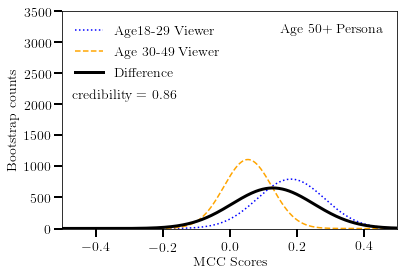

In [44]:
complete_visualization(bootstrap_Young_Old, 'Age18-29 Viewer', bootstrap_Middle_Old,'Age 30-49 Viewer', 'Difference','Age 50+ Persona',3500,0.5)

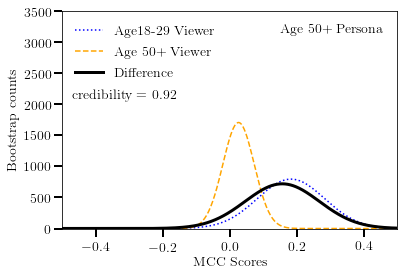

In [45]:
complete_visualization(bootstrap_Young_Old, 'Age18-29 Viewer', bootstrap_Old_Old,'Age 50+ Viewer', 'Difference','Age 50+ Persona',3500,0.5)


In [46]:
# Male_Heterophily	"[[507 151]
#   [450 170]]"
# Male_Homophily	"[[355 105]
#   [320 138]]"

#Argument key: TP,FN,FP,TN
bootstrap_homoMale = generate_corrcoeff(355,105,320,138)
bootstrap_heteroMale = generate_corrcoeff(507,151,450,170)

result_bias_Male = ttest_ind(bootstrap_homoMale,bootstrap_heteroMale,equal_var=False)
print(result_bias_Male)

Ttest_indResult(statistic=73.92277445170099, pvalue=0.0)


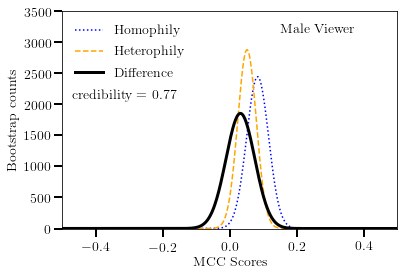

In [47]:
#Argument key:  array and label, demographic array

complete_visualization(bootstrap_homoMale,'Homophily',bootstrap_heteroMale,'Heterophily', 'Difference', 'Male Viewer',3500,0.5)


In [48]:
# Female_Heterophily	"[[259 120]
#   [259 105]]"
# Female_Homophily	"[[413 137]
#   [400 143]]"

#Argument key: TP,FN,FP,TN
bootstrap_homoFemale = generate_corrcoeff(413,137,400,143)
bootstrap_heteroFemale = generate_corrcoeff(259,120,259,105)

result_bias_Female = ttest_ind(bootstrap_homoFemale,bootstrap_heteroFemale,equal_var=False)
print(result_bias_Female)


Ttest_indResult(statistic=98.48039489860277, pvalue=0.0)


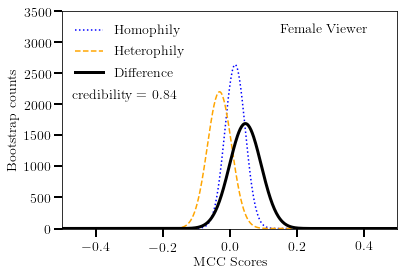

In [51]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_homoFemale,'Homophily',bootstrap_heteroFemale,'Heterophily', 'Difference', 'Female Viewer',3500,0.5)


In [50]:
# PersonofColor_Heterophily	"[[244 91]
#   [262 131]]"
# PersonofColor_Homophily	"[[306 79]
#   [233 90]]"

#Argument key: TP,FN,FP,TN
bootstrap_homoPOC = generate_corrcoeff(306,79,233,90)
bootstrap_heteroPOC = generate_corrcoeff(244,91,262,131)

result_bias_POC = ttest_ind(bootstrap_homoPOC,bootstrap_heteroPOC,equal_var=False)
print(result_bias_POC)



Ttest_indResult(statistic=35.93118976278085, pvalue=4.921984549291426e-274)


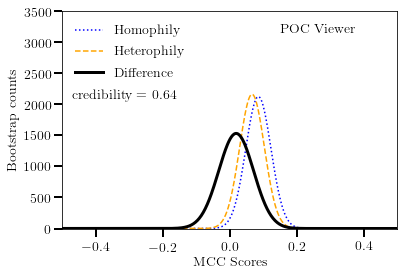

In [52]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_homoPOC,'Homophily',bootstrap_heteroPOC,'Heterophily', 'Difference', 'POC Viewer',3500,0.5)


In [53]:
# Age1829_Heterophily	"[[152 49]
#   [117 65]]"
# Age1829_Homophily	"[[117 28]
#   [107 51]]"

#Argument key: TP,FN,FP,TN
bootstrap_homo1829 = generate_corrcoeff(117,28,107,51)
bootstrap_hetero1829 = generate_corrcoeff(152,49,117,65)

result_bias_1829 = ttest_ind(bootstrap_homo1829,bootstrap_hetero1829,equal_var=False)
print(result_bias_1829)


Ttest_indResult(statistic=32.63111135516938, pvalue=1.527135951684731e-227)


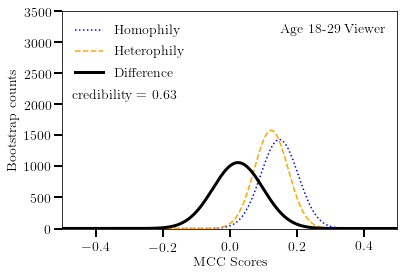

In [55]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_homo1829,'Homophily',bootstrap_hetero1829,'Heterophily', 'Difference', 'Age 18-29 Viewer',3500,0.5)


In [56]:
# Age3049_Heterophily	"[[178 54]
#   [173 62]]"
# Age304_Homophily	"[[235 64]
#   [243 65]]"

#Argument key: TP,FN,FP,TN
bootstrap_homo3049 = generate_corrcoeff(235,64,243,65)
bootstrap_hetero3049 = generate_corrcoeff(178,54,173,62)

result_bias_3049 = ttest_ind(bootstrap_homo3049,bootstrap_hetero3049,equal_var=False)
print(result_bias_3049)


Ttest_indResult(statistic=-64.40278615456435, pvalue=0.0)


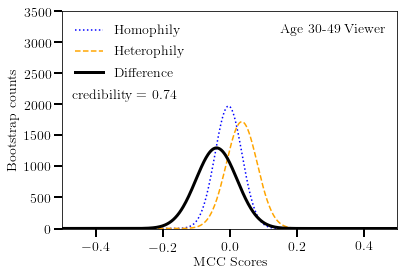

In [57]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_homo3049,'Homophily',bootstrap_hetero3049,'Heterophily', 'Difference', 'Age 30-49 Viewer',3500,0.5)
#

In [58]:
# Age50Plus_Heterophily	"[[677 255]
#   [636 251]]"
# Age50Plus_Homophily	"[[175 63]
#   [153 62]]"

#Argument key: TP,FN,FP,TN
bootstrap_homo50p = generate_corrcoeff(175,63,153,62)
bootstrap_hetero50p = generate_corrcoeff(677,255,636,251)

result_bias_50p = ttest_ind(bootstrap_homo50p,bootstrap_hetero50p,equal_var=False)
print(result_bias_50p)


Ttest_indResult(statistic=30.973844387752877, pvalue=5.032447722102578e-204)


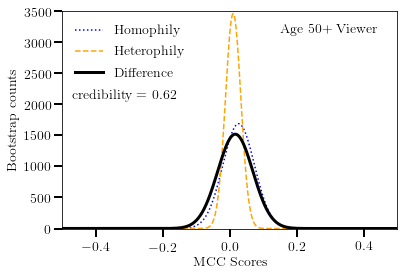

In [59]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_homo50p,'Homophily',bootstrap_hetero50p,'Heterophily', 'Difference', 'Age 50+ Viewer',3500,0.5)


In [60]:
# Knowledgeable_about_deepfakes	"[[315 95]
#   [278 120]]"
# Not_Knowledgeable_about_deepfakes	"[[1169 411]
#   [1104 420]]"

#Argument key: TP,FN,FP,TN
bootstrap_K = generate_corrcoeff(315,95,278,120)
bootstrap_NK= generate_corrcoeff(1169,411,1104,420)

result_bias_K = ttest_ind(bootstrap_K,bootstrap_NK,equal_var=False)
print(result_bias_K)


Ttest_indResult(statistic=157.47946878808912, pvalue=0.0)


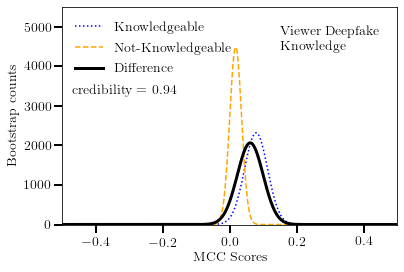

In [82]:

#Argument key:  array and label, demographic array
complete_visualization(bootstrap_K,'Knowledgeable',bootstrap_NK,'Not-Knowledgeable', 'Difference', 'Viewer Deepfake \n Knowledge',5500,0.5)


In [83]:
# social_media_frequently	"[[1388 1294]
#   [ 444 496]]"
# social_media_infrequently	"[[141 128]
#   [ 67 58]]"
#Confusion Matrix  [[TP  FN ]
#  [FP  TN ]]
#Argument key: TP,FN,FP,TN
bootstrap_F = generate_corrcoeff(1388,1294,444,496)
bootstrap_NF= generate_corrcoeff(141,128,67,58)

result_bias_F = ttest_ind(bootstrap_F,bootstrap_NF,equal_var=False)
print(result_bias_F)


Ttest_indResult(statistic=95.82620810885413, pvalue=0.0)


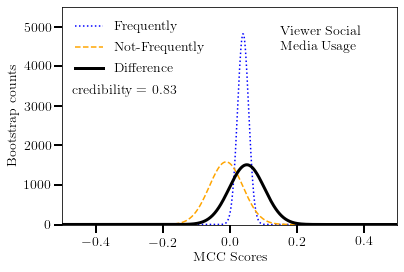

In [84]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_F,'Frequently',bootstrap_NF,'Not-Frequently',  'Difference', 'Viewer Social \n Media Usage',5500,0.5)
